In [273]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from te import transfer_entropy
from cjte import calculate_cjte

In [274]:
def calc_rr_map_sap(
    signal: np.array,
    sampling_rate: int = 200,
    mindelay: float = 0.3,
) -> dict[np.array]:
    # Fill missing values
    signal = nk.signal_fillmissing(signal)
    cleaned_signal = nk.ppg_clean(signal, sampling_rate=sampling_rate, method="elgendi")
    peaks_info = nk.ppg_findpeaks(
        cleaned_signal, sampling_rate=sampling_rate, method="elgendi", mindelay=mindelay
    )
    peaks = peaks_info["PPG_Peaks"]
    rr = np.diff(peaks) / sampling_rate * 1000
    sap = np.array([signal[peak] for peak in peaks])[1:]
    map = np.array([np.mean(signal[peaks[i-1]:peaks[i]]) for i, _ in enumerate(peaks) if i > 0])

    return {"HP": 1 / rr * 1000, "SAP": sap, "MAP": map}

In [275]:
def calculate_mcbfv(    
    signal: np.array,
    sampling_rate: int = 200,
    mindelay: float = 0.3):
    # Fill missing values
    signal = nk.signal_fillmissing(signal)
    cleaned_signal = nk.ppg_clean(signal, sampling_rate=200, method="elgendi") *-1 # invert signal to find minima
    peaks_info = nk.ppg_findpeaks(
            cleaned_signal, sampling_rate=200, method="elgendi", mindelay=0.3
        )
    peaks = peaks_info["PPG_Peaks"]

    mcbfv = np.array([np.mean(signal[peaks[i-1]:peaks[i]]) for i, _ in enumerate(peaks) if i > 0])
    return mcbfv

In [276]:
def plot_signals(signals):
    fig, axs = plt.subplots(5, 1, figsize=(20, 10))
    for i, (key, value) in enumerate(signals.items()):
        axs[i].plot(value)
        axs[i].set_title(key)
    plt.show()

In [277]:
def calculate_te(signals):
    te = {}
    te['HP->SAP'] = transfer_entropy(signals["HP"], signals["SAP"])
    te['SAP->HP'] = transfer_entropy(signals["SAP"], signals["HP"])
    # adjust lenght of MAP and MCBFV
    min_len = min(len(signals["MAP"]), len(signals["MCBFV"]))
    signals["MAP"] = signals["MAP"][:min_len]
    signals["MCBFV"] = signals["MCBFV"][:min_len]
    te['MCBFV->MAP'] = transfer_entropy(signals["MCBFV"], signals["MAP"])
    te['MAP->MCBFV'] = transfer_entropy(signals["MAP"], signals["MCBFV"])
    return te

In [278]:
def conditional_joint_transfer_entropy(signals):
    cjte = {}
    r_widnowed = np.array_split(signals["R"], len(signals["HP"]))
    signalsr_matched = np.array([np.mean(window) for window in r_widnowed])
    cjte['HP->SAP'] = calculate_cjte(signals["HP"], signals["SAP"], signalsr_matched)
    cjte['SAP->HP'] = calculate_cjte(signals["SAP"], signals["HP"], signalsr_matched)

    min_len = min(len(signals["MAP"]), len(signals["MCBFV"]))
    signals["MAP"] = signals["MAP"][:min_len]
    signals["MCBFV"] = signals["MCBFV"][:min_len]
    r_widnowed = np.array_split(signals["R"], len(signals["MAP"]))
    signalsr_matched = np.array([np.mean(window) for window in r_widnowed])
    cjte['MCBFV->MAP'] = calculate_cjte(signals["MCBFV"], signals["MAP"], signalsr_matched)
    cjte['MAP->MCBFV'] = calculate_cjte(signals["MAP"], signals["MCBFV"], signalsr_matched)
    return cjte

In [279]:
def plot_results(data, title):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data)
    ax.set_title(title)
    ax.set_xticklabels(['BASELINE', '6B', '10B', '15B'])
    return fig

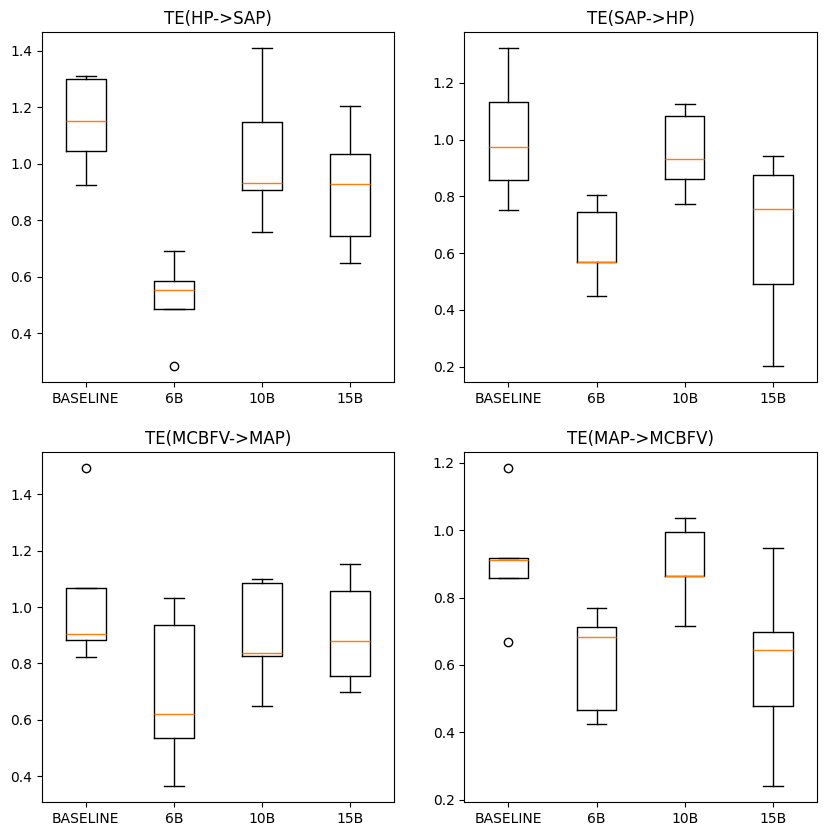

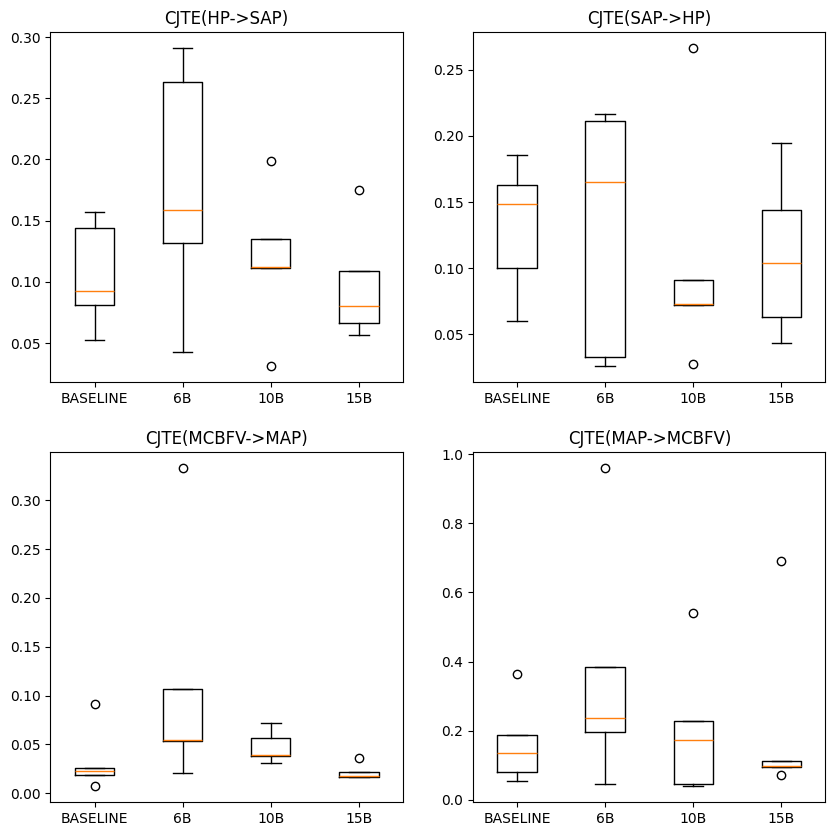

In [280]:
valid_datasets = [1, 6, 19, 22, 23] 

location_baseline = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_BASELINE/OCH_{on}_CLEAN_CB_BASELINE.csv'
location_6 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_6_BREATHS/OCH_{on}_CLEAN_CB_6.csv'
location_10 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_10_BREATHS/OCH_{on}_CLEAN_CB_10.csv'
location_15 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_15_BREATHS/OCH_{on}_CLEAN_CB_15.csv'
rc_hp_sap = []
rc_sap_hp = []
rc_mcbfv_map = []
rc_map_mcbfv = []
rc_hp_sap_cjte = []
rc_sap_hp_cjte = []
rc_mcbfv_map_cjte = []
rc_map_mcbfv_cjte = []
for loc in [location_baseline, location_6, location_10, location_15]:
    r_hp_sap = []
    r_sap_hp = []
    r_mcbfv_map = []
    r_map_mcbfv = []
    r_hp_sap_cjte = []
    r_sap_hp_cjte = []
    r_mcbfv_map_cjte = []
    r_map_mcbfv_cjte = []
    for on in valid_datasets:
        location = loc(on)
        abp_signal = pd.read_csv(location, sep=';', decimal=',')['abp_cnap[mmHg]'].values
        fv = pd.read_csv(location, sep=';', decimal=',')['fvl'].values
        r = pd.read_csv(location, sep=';', decimal=',')['rr[rpm]'].values
        signals = calc_rr_map_sap(abp_signal)
        signals['MCBFV'] = calculate_mcbfv(fv)
        signals['R'] = r

        #plot_signals(signals)
        #print(location)

        results = calculate_te(signals)
        r_hp_sap.append(results['HP->SAP'])
        r_sap_hp.append(results['SAP->HP'])
        r_mcbfv_map.append(results['MCBFV->MAP'])
        r_map_mcbfv.append(results['MAP->MCBFV'])
        results_cjte = conditional_joint_transfer_entropy(signals)
        r_hp_sap_cjte.append(results_cjte['HP->SAP'])
        r_sap_hp_cjte.append(results_cjte['SAP->HP'])
        r_mcbfv_map_cjte.append(results_cjte['MCBFV->MAP'])
        r_map_mcbfv_cjte.append(results_cjte['MAP->MCBFV'])
    rc_hp_sap.append(r_hp_sap)
    rc_sap_hp.append(r_sap_hp)
    rc_mcbfv_map.append(r_mcbfv_map)
    rc_map_mcbfv.append(r_map_mcbfv)
    rc_hp_sap_cjte.append(r_hp_sap_cjte)
    rc_sap_hp_cjte.append(r_sap_hp_cjte)
    rc_mcbfv_map_cjte.append(r_mcbfv_map_cjte)
    rc_map_mcbfv_cjte.append(r_map_mcbfv_cjte)

#fig_1 = plot_results(rc_hp_sap, 'HP->SAP')
#fig_2 = plot_results(rc_sap_hp, 'SAP->HP')
#fig_3 = plot_results(rc_mcbfv_map, 'MCBFV->MAP')
#fig_4 = plot_results(rc_map_mcbfv, 'MAP->MCBFV')
# make 1 plot with 4 subplots from my figures above
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].boxplot(rc_hp_sap)
axs[0, 0].set_title('TE(HP->SAP)')
axs[0, 1].boxplot(rc_sap_hp)
axs[0, 1].set_title('TE(SAP->HP)')
axs[1, 0].boxplot(rc_mcbfv_map)
axs[1, 0].set_title('TE(MCBFV->MAP)')
axs[1, 1].boxplot(rc_map_mcbfv)
axs[1, 1].set_title('TE(MAP->MCBFV)')
for i in range(2):
    for j in range(2):
        axs[i, j].set_xticklabels(['BASELINE', '6B', '10B', '15B'])
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].boxplot(rc_hp_sap_cjte)
axs[0, 0].set_title('CJTE(HP->SAP)')
axs[0, 1].boxplot(rc_sap_hp_cjte)
axs[0, 1].set_title('CJTE(SAP->HP)')
axs[1, 0].boxplot(rc_mcbfv_map_cjte)
axs[1, 0].set_title('CJTE(MCBFV->MAP)')
axs[1, 1].boxplot(rc_map_mcbfv_cjte)
axs[1, 1].set_title('CJTE(MAP->MCBFV)')
for i in range(2):
    for j in range(2):
        axs[i, j].set_xticklabels(['BASELINE', '6B', '10B', '15B'])
plt.show()



In [281]:
def calculate_te(signals):
    te = {}
    te['HP->SAP'] = transfer_entropy(signals["HP"], signals["SAP"])
    te['SAP->HP'] = transfer_entropy(signals["SAP"], signals["HP"])
    return te

In [282]:
def conditional_joint_transfer_entropy(signals):
    cjte = {}
    r_widnowed = np.array_split(signals["R"], len(signals["HP"]))
    signalsr_matched = np.array([np.mean(window) for window in r_widnowed])
    cjte['HP->SAP'] = calculate_cjte(signals["HP"], signals["SAP"], signalsr_matched)
    cjte['SAP->HP'] = calculate_cjte(signals["SAP"], signals["HP"], signalsr_matched)
    return cjte

data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_1/CLEAN_DATA_BASELINE/OCH_1_CLEAN_CB_BASELINE.csv
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_2/CLEAN_DATA_BASELINE/OCH_2_CLEAN_CB_BASELINE.csv
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_4/CLEAN_DATA_BASELINE/OCH_4_CLEAN_CB_BASELINE.csv
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_5/CLEAN_DATA_BASELINE/OCH_5_CLEAN_CB_BASELINE.csv
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_6/CLEAN_DATA_BASELINE/OCH_6_CLEAN_CB_BASELINE.csv
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_8/CLEAN_DATA_BASELINE/OCH_8_CLEAN_CB_BASELINE.csv
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_9/CLEAN_DATA_BASELINE/OCH_9_CLEAN_CB_BASELINE.csv
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_12/CLEAN_DATA_BASELINE/OCH_12_CLEAN_CB_BASELINE.csv
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_13/CLEAN_DATA_BASELINE/OCH_13_CLEAN_CB_BASELINE.csv
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_16/CLEAN_DATA_BASELINE/OCH_16_CLEAN_CB_BASELINE.csv
data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_18/CLEAN_DATA_BASELIN

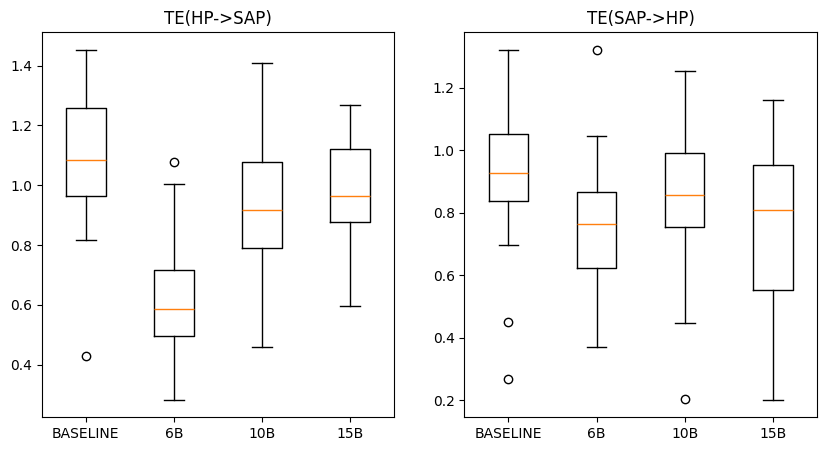

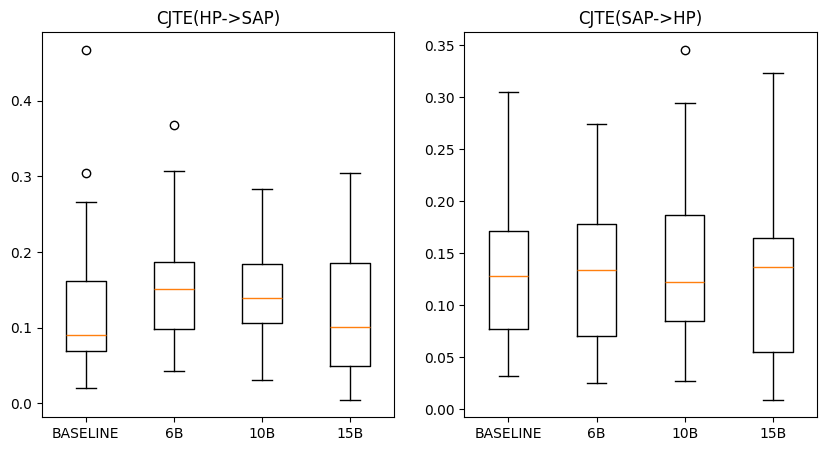

In [285]:
valid_datasets = [i for i in range(1, 38) if i not in [3, 7, 14, 15, 10, 11, 17, 27, 35]]

location_baseline = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_BASELINE/OCH_{on}_CLEAN_CB_BASELINE.csv'
location_6 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_6_BREATHS/OCH_{on}_CLEAN_CB_6.csv'
location_10 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_10_BREATHS/OCH_{on}_CLEAN_CB_10.csv'
location_15 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_15_BREATHS/OCH_{on}_CLEAN_CB_15.csv'
rc_hp_sap = []
rc_sap_hp = []
rc_hp_sap_cjte = []
rc_sap_hp_cjte = []

for loc in [location_baseline, location_6, location_10, location_15]:
    r_hp_sap = []
    r_sap_hp = []
    r_hp_sap_cjte = []
    r_sap_hp_cjte = []
    for on in valid_datasets:
        location = loc(on)
        abp_signal = pd.read_csv(location, sep=';', decimal=',')['abp_cnap[mmHg]'].values
        r = pd.read_csv(location, sep=';', decimal=',')['rr[rpm]'].values
        signals = calc_rr_map_sap(abp_signal)
        signals['R'] = r

        #print(location)
        #plot_signals(signals)

        results = calculate_te(signals)
        r_hp_sap.append(results['HP->SAP'])
        r_sap_hp.append(results['SAP->HP'])
        print(location)
        results_cjte = conditional_joint_transfer_entropy(signals)
        r_hp_sap_cjte.append(results_cjte['HP->SAP'])
        r_sap_hp_cjte.append(results_cjte['SAP->HP'])
    rc_hp_sap.append(r_hp_sap)
    rc_sap_hp.append(r_sap_hp)
    rc_hp_sap_cjte.append(r_hp_sap_cjte)
    rc_sap_hp_cjte.append(r_sap_hp_cjte)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].boxplot(rc_hp_sap)
axs[0].set_title('TE(HP->SAP)')
axs[0].set_xticklabels(['BASELINE', '6B', '10B', '15B'])
axs[1].boxplot(rc_sap_hp)
axs[1].set_title('TE(SAP->HP)')
axs[1].set_xticklabels(['BASELINE', '6B', '10B', '15B'])
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].boxplot(rc_hp_sap_cjte)
axs[0].set_title('CJTE(HP->SAP)')
axs[0].set_xticklabels(['BASELINE', '6B', '10B', '15B'])
axs[1].boxplot(rc_sap_hp_cjte)
axs[1].set_title('CJTE(SAP->HP)')
axs[1].set_xticklabels(['BASELINE', '6B', '10B', '15B'])
plt.show()

